In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_fscore_support
from sklearn.svm import OneClassSVM
from scipy.stats import multivariate_normal
from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope

%matplotlib inline

In [3]:
def plot_hist(df,threshold=0.7,save=0):
    fig = plt.figure(figsize=(10,10))
    df['Label'].hist(bins = 100)
    plt.title('Histogram over relKa',fontsize=16)
    plt.xlabel('relKa')
    plt.plot([threshold,threshold],[0,3500],'r--')
    
    if save:
        plt.savefig('Hist_GSM1586782_ScrWT_Exd_14mer.jpg')
        

def get_info(df):
    tmp = list(np.linspace(0,1,11))
    for num in tmp:
        print('# datapoints {:.2f} above {}'.format(num,df[df['Label'] > num].shape[0]))

def get_class(df,thres=0.7,delte=True):
    df['Class'] = 0
    df.loc[df['Label']>=thres,'Class'] = 1
    if delte:
        df.drop(['Label'],axis=1,inplace=True)
        return
    return df

def get_normal(df,num1=0,num2=-1,feature=1):
    data_sc = pd.DataFrame(StandardScaler().fit_transform(df.loc[:,df.columns[num1:num2]]))
    
    if feature:
        data_sc['Mean'] = df.loc[:,df.columns[num1:num2]].mean(axis=1)
        data_sc['Var'] = df.loc[:,df.columns[num1:num2]].var(axis=1)
        data_sc['Min'] = df.loc[:,df.columns[num1:num2]].min(axis=1)
        data_sc['Max'] = df.loc[:,df.columns[num1:num2]].max(axis=1)
        data_sc['Median'] = df.loc[:,df.columns[num1:num2]].median(axis=1)
        data_sc['Sum'] = df.loc[:,df.columns[num1:num2]].sum(axis=1)
    
    data_sc['Class'] = df['Class']
    return data_sc

def get_testdata(df):
    tfbs = df[df.Class == 1]
    ntfbs = df[df.Class == 0]
    #shuffeled_data = non_tfbs.sample(frac=1, random_state=42)
    # prepare df_train
    train = ntfbs.sample(frac=0.8, random_state = 42)
    train.drop(['Class'],axis=1,inplace=True)
    
    tmp = ntfbs.loc[list(set(ntfbs.index)-set(train.index)),:]
    test = pd.concat([tmp,pd.DataFrame(tfbs)])
    test_class = test.loc[:,'Class'].copy()
    test.drop(['Class'],axis = 1,inplace=True)
    tfbs.drop(['Class'],axis=1, inplace=True)
    
    # return train set, test set, test class, df[Class==1]
    return train, test, test_class, tfbs

def get_prec(df):
    return (df[df['Class']==1].shape[0]/df.shape[0])

def get_labels(y):
    tmp = np.zeros((y.shape[0]))
    tmp[y == -1] = 1
    return tmp

# Isolation Forest
def get_isfo(X,n_es=1050,perc=0.1):
    isofo = IsolationForest(n_estimators = n_es, max_features = 1.0, max_samples=1.0, 
                        behaviour="new", bootstrap=False, random_state=42,
                        contamination = perc).fit(X)
    return isofo

# OneClassSVM
def get_ocsvm(X,bound=0.01,perc=0.1):
    ocsvm = OneClassSVM(nu=bound,gamma='scale').fit(X)
    return ocsvm

def get_elliptic_env(df,sf=0.99,per=0.1):
    cov = EllipticEnvelope(support_fraction = sf, contamination = per).fit(df)
    return cov

def get_eval(model,X,y_truth):
    y_pred = model.predict(X)
    n_errors = (get_labels(y_pred) != y_truth).sum()
    #print('Number of Errors {}'.format(n_errors))
    return y_pred, n_errors

def get_results(y_pred,y_truth):
    y_pred = get_labels(y_pred)
    cm = confusion_matrix(y_pred,y_test)
    # get f1score
    precision,recall,f1, support  = precision_recall_fscore_support(y_pred,y_test, average='binary')
    return cm, precision, recall, f1

def plot_cm(y_test,y_pred,save=0,name='CM.jpg'):
    df_cm = pd.DataFrame(confusion_matrix(y_test,get_labels(y_pred)),index = ['inlier','outlier'],columns=['inlier','outlier'])
    fig, ax = plt.subplots(figsize=(8,6))
    sns.set(font_scale=1.4) # for label size
    sns.heatmap(df_cm, annot=True, annot_kws={"size": 16},fmt='g',cbar=False)
    ax.set_ylim([0,2])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')

    if save:
        plt.savefig(name)

# Look at the data

# datapoints 0.00 above 68976
# datapoints 0.10 above 68976
# datapoints 0.20 above 67734
# datapoints 0.30 above 41532
# datapoints 0.40 above 17193
# datapoints 0.50 above 7264
# datapoints 0.60 above 2942
# datapoints 0.70 above 1128
# datapoints 0.80 above 354
# datapoints 0.90 above 86
# datapoints 1.00 above 0


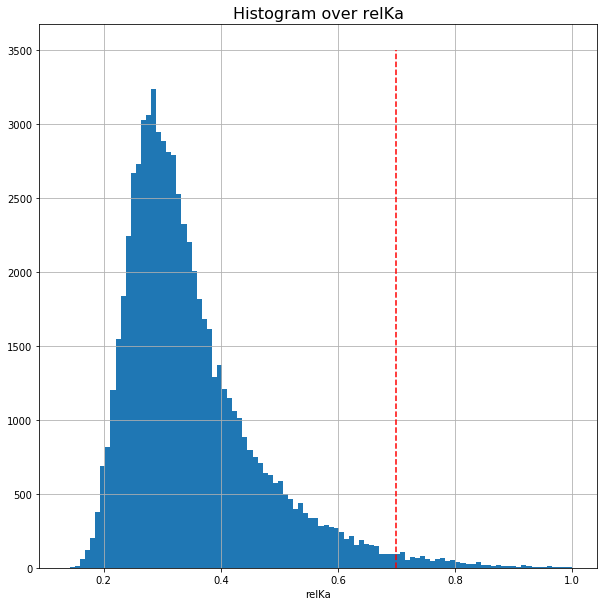

In [4]:
data = pd.read_csv('../data_cgDNA/stiffness/GSM1586782_ScrWT_Exd_14mer_cg_eigs.txt')
plot_hist(data,threshold=0.7,save=0)
get_info(data)

# Prepare data

In [5]:
# get in- and outlier
get_class(data)
# normalize data and calculate features
data_sc=get_normal(data,feature=0)
# get train and test data
train_data, test_data, y_test, tfbs = get_testdata(data_sc)
# get percentage of outlier
perc = get_prec(data_sc)

/home/jate1/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


# Calcualte Isolation Forest

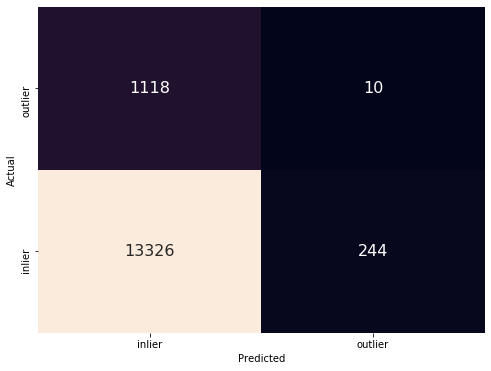

In [6]:
# get trained isolation forest
isof = get_isfo(train_data,perc=perc)
# evaluate isolation forest
y_pred, n_errors = get_eval(isof,test_data,y_test)
# look at the Class of the predicted outliers
#data.loc[test_data[y_pred == -1].index,'Class']
# calculate confusion matrix
confusion_matrix(y_test,get_labels(y_pred))
plot_cm(y_test,y_pred)
plt.savefig('../CM_isoforest.jpg')

In [18]:
y_pred[get_labels(y_pred)==1]

array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1

# Calculate One Class SVM

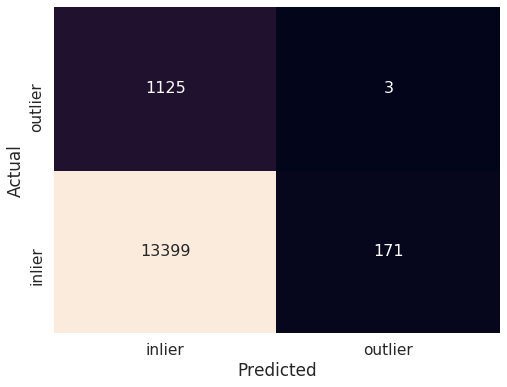

In [25]:
# get trained ocsvm
ocsvm = get_ocsvm(train_data,perc=perc)
# evaluate the model
y_pred, n_errors = get_eval(ocsvm,test_data,y_test)
# look at the prediction 
#data.loc[test_data[y_pred == -1].index,'Class']
# calculate confusion matrix
confusion_matrix(y_test,get_labels(y_pred))
plot_cm(y_test,y_pred)

# Calculate Elliptic Envelop

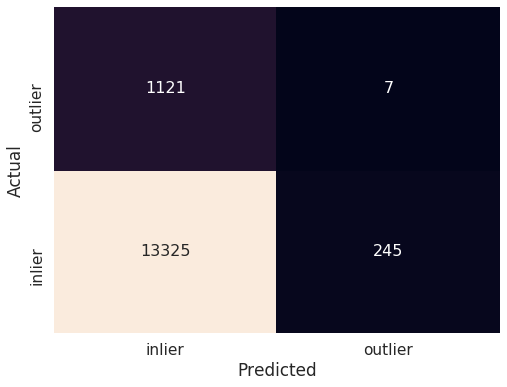

In [27]:
# get trained elliptic envelop
cov = get_elliptic_env(train_data,sf=0.95,per=perc)
# get error of prediction
y_pred, n_errors = get_eval(cov,test_data,y_test)
# look at predicted outliers
#data.loc[test_data[y_pred == -1].index,'Class']
# calcualte confusion matrix
confusion_matrix(y_test,get_labels(y_pred))
# calculate confusion outliers and f1
plot_cm(y_test,y_pred)

# Different Dataset

# datapoints 0.00 above 68976
# datapoints 0.10 above 68976
# datapoints 0.20 above 67734
# datapoints 0.30 above 41532
# datapoints 0.40 above 17193
# datapoints 0.50 above 7264
# datapoints 0.60 above 2942
# datapoints 0.70 above 1128
# datapoints 0.80 above 354
# datapoints 0.90 above 86
# datapoints 1.00 above 0


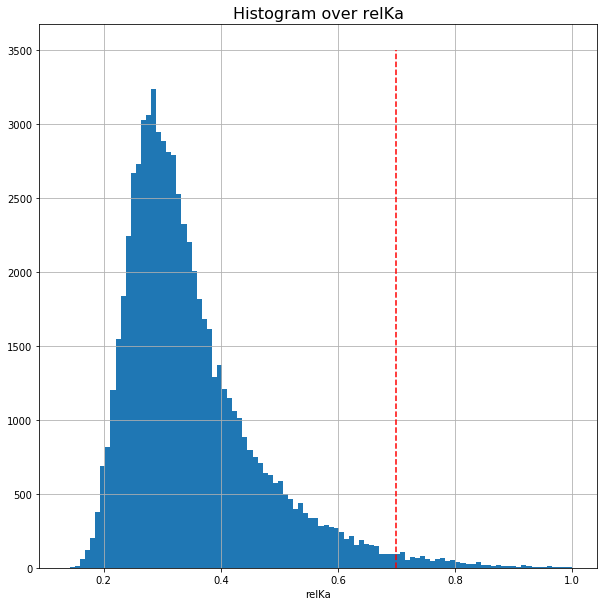

In [10]:
data = pd.read_csv('../data_cgDNA/features/GSM1586782_ScrWT_Exd_14mer_features.txt')
data.drop(['Unnamed: 0'],axis=1,inplace=True)
data.rename(columns={'relKa': 'Label'},inplace = True)
#data.head()
plot_hist(data,threshold=0.7,save=0)
get_info(data)

In [11]:
# get in- and outlier
get_class(data)
# normalize data and calculate features
data_sc=get_normal(data,feature=0)
# get train and test data
train_data, test_data, y_test, tfbs = get_testdata(data_sc)
# get percentage of outlier
perc = get_prec(data_sc)

/home/jate1/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


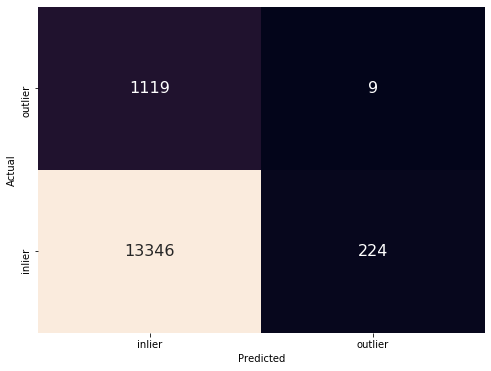

In [12]:
# get trained isolation forest
isof = get_isfo(train_data,perc=perc)
# evaluate isolation forest
y_pred, n_errors = get_eval(isof,test_data,y_test)
# look at the Class of the predicted outliers
#data.loc[test_data[y_pred == -1].index,'Class']
# calculate confusion matrix
confusion_matrix(y_test,get_labels(y_pred))
plot_cm(y_test,y_pred)
#plt.savefig('../CM_isoforest.jpg')

0         1         2         3         4         5         6   \
17658  0.411488  0.608154 -0.911881 -1.900306  0.411488 -1.151226 -2.034084   
54719  1.868993  0.311998 -0.335133 -0.464590  1.868993  2.027449 -0.702569   
9569   0.922003  0.889681  0.407317 -0.712345  0.922003 -0.344797 -0.839902   
14872  1.006041  1.379282  0.247489 -1.129167  1.006041  0.623650 -1.286940   
48233 -0.393400  0.685972 -1.384845 -0.104440 -0.393400 -0.224368 -0.009420   
...         ...       ...       ...       ...       ...       ...       ...   
52929  0.419898  0.924332  0.927559  0.076154  0.419898 -0.208387  0.015969   
6051   0.074254  1.193819  1.373694 -0.111985  0.074254  0.084569 -0.105591   
18238 -2.116072  1.106415 -1.187744  0.889007 -2.116072  0.127649  1.291548   
48778  0.716830  1.030649 -0.316485 -0.854212  0.716830  0.156153 -0.954463   
68177  1.869280 -0.156073  0.156370  1.140148  1.869280  2.172244  0.823150   

             7         8         9   ...        18        19        20  \
17658 -1.412379 -0.902019  0.199322  ... -0.203046  1.554206 -2.015342   
54719  1.073752  0.334651 -0.118734  ...  0.130001 -0.352265  1.367004   
9569   0.336257 -0.032366  0.085744  ... -0.785875  0.458647 -1.304882   
14872 -0.389457  0.191386 -1.044278  ...  0.430676  0.408489 -1.105127   
48233 -0.492868  0.856829  0.236470  ... -0.493410 -1.668509 -0.490658   
...         ...       ...       ...  ...       ...       ...       ...   
52929 -0.146981  0.654058  1.099033  ...  0.791157  0.682611  0.476793   
6051   0.494437  0.688248  1.529261  ... -0.738917 -1.209784  1.269551   
18238 -1.212975  0.955540  0.429621  ...  1.404643  0.758390 -0.040990   
48778 -0.705503 -0.036593  0.069276  ...  0.858880 -0.013701 -0.223631   
68177  3.491464  0.515384 -1.928355  ... -2.301971 -0.407336 -1.006190   

             21        22        23        24        25        26        27  
17658  0.316368  0.968657 -1.239489 -1.382886  0.316368 -0.102237 -1.047834  
54719 -1.928879 -1.717545  0.360521  1.373817 -1.928879 -0.521821  0.430827  
9569  -0.705838  1.014466 -1.220860 -0.508129 -0.705838 -0.295675 -0.712488  
14872 -2.154106 -2.228628 -0.281586  0.825434 -2.154106  2.505378 -0.103495  
48233 -0.239036 -1.125950  0.274884  0.260620 -0.239036  1.054159  0.110633  
...         ...       ...       ...       ...       ...       ...       ...  
52929 -1.238762 -0.054331  0.490373  0.543640 -1.238762  0.133496 -0.025225  
6051  -0.298756 -0.844255 -0.219562  0.982792 -0.298756  0.605466  0.692058  
18238  1.797413 -0.982735 -0.026119 -0.205545  1.797413  1.172089  0.575205  
48778 -1.195823 -0.139880 -1.288873 -0.354021 -1.195823 -0.024921 -0.763074  
68177 -1.684163 -1.056525  1.495412 -1.418323 -1.684163 -0.686643 -1.830894  

[54278 rows x 28 columns]